# Datahåndtering og -wrangling af MF'eres tweets

In [1]:
import pandas as pd
import json
import os
import re
import datetime
import sys
import numpy as np #bruges til tal og grafer
import matplotlib.pyplot as plt #bruges til grafer
!{sys.executable} -m pip install plotnine
from plotnine import *
import spacy
import nltk 
nltk.download('punkt')
!{sys.executable} -m pip install scikit-learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

[nltk_data] Downloading package punkt to /home/ucloud/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 19.2 MB/s eta 0:00:0000:0100:01


In [2]:
data_path = os.path.join("..", "data")
tw_file_name = "poltweet_set.gz"
df_path = os.path.join(data_path, tw_file_name)

In [3]:
tweet_df = pd.read_csv(df_path)
parl_mem = pd.read_csv(os.path.join(data_path, "Folketinget_twitter.csv"), sep = ";")

/tmp/ipykernel_325/1355655951.py:1: DtypeWarning: Columns (19,20,36,37,38,87) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
tweet_df.head(25)

,Unnamed: 0.2,level_0,Unnamed: 0.1,index,Unnamed: 0,created_at,id,id_str,full_text,truncated,...,user_following,user_follow_request_sent,user_notifications,user_translator_type,user_withheld_in_countries,hashtags.1,symbols.1,user_mentions.1,urls.1,media.1
0,0,0,0,0,0,Tue Apr 06 20:55:45 +0000 2021,1379538341528494000,1379538341528494083,RT @PoulHoi: FTs opgørelse over overdødelighed...,False,...,NaN,NaN,NaN,none,NaN,NaN,[],"[{'screen_name': 'PoulHoi', 'name': 'Poul Hoi'...",[],NaN
1,1,1,1,1,1,Tue Apr 06 06:29:14 +0000 2021,1379320273313407000,1379320273313406978,"@mikker Hej Mikkel. Ping modtaget. Håber, at h...",False,...,NaN,NaN,NaN,none,NaN,NaN,[],"[{'screen_name': 'mikker', 'name': 'Mikkel Mal...",[],NaN
2,2,2,2,2,2,Mon Apr 05 06:18:35 +0000 2021,1378955203941109800,1378955203941109762,"@veloropa Flotte, sigende fotos. Fedt, at Saga...",False,...,NaN,NaN,NaN,none,NaN,NaN,[],"[{'screen_name': 'veloropa', 'name': 'Veloropa...",[],NaN
3,3,3,3,3,3,Sun Apr 04 20:25:07 +0000 2021,1378805855357956000,1378805855357956103,"@jakobherskind @Kildegaardens Ja, måske. Men m...",False,...,NaN,NaN,NaN,none,NaN,NaN,[],"[{'screen_name': 'jakobherskind', 'name': 'Jak...",[],NaN
4,4,4,4,4,4,Sun Apr 04 19:07:07 +0000 2021,1378786226367557600,1378786226367557633,@veloropa Er der en egentligt nederlands/flams...,False,...,NaN,NaN,NaN,none,NaN,NaN,[],"[{'screen_name': 'veloropa', 'name': 'Veloropa...",[],NaN
5,5,5,5,5,5,Sun Apr 04 14:46:05 +0000 2021,1378720534326820900,1378720534326820869,Send fregatterne på søen og F16 i luften! Kasp...,False,...,NaN,NaN,NaN,none,NaN,NaN,[],[],[],"[{'id': 1378720528949727200, 'id_str': '137872..."
6,6,6,6,6,6,Wed Mar 31 16:16:25 +0000 2021,1377293715472015400,1377293715472015363,"@MikkelFrey “Det er en syg høne, der har lagt ...",False,...,NaN,NaN,NaN,none,NaN,NaN,[],"[{'screen_name': 'MikkelFrey', 'name': 'Mikkel...",[],NaN
7,7,7,7,7,7,Wed Mar 31 09:08:50 +0000 2021,1377186110124683300,1377186110124683278,@LAggerstroem Tillykke. Og tak for det sidste ...,False,...,NaN,NaN,NaN,none,NaN,NaN,[],"[{'screen_name': 'LAggerstroem', 'name': 'Loui...",[],NaN
8,8,8,8,8,8,Tue Aug 02 17:45:32 +0000 2022,1554523811470577700,1554523811470577670,"@MadsAakjaer Nej, beregningerne er ikke lavet ...",False,...,NaN,NaN,NaN,none,NaN,NaN,[],"[{'screen_name': 'MadsAakjaer', 'name': 'Mads ...",[],NaN
9,9,9,9,9,9,Tue Aug 02 15:01:36 +0000 2022,1554482555893809200,1554482555893809153,@MadsAakjaer Ikke sandt. https://t.co/RoXPw4TGOf,False,...,NaN,NaN,NaN,none,NaN,NaN,[],"[{'screen_name': 'MadsAakjaer', 'name': 'Mads ...","[{'url': 'https://t.co/RoXPw4TGOf', 'expanded_...",NaN


In [5]:
# opretter liste med centrale variabler
central_vars = ['level_0', 'created_at', 'id', 'id_str', 'full_text', 
                  'user_screen_name', 'user_name', 
                  'user_description', 'user_lang', "in_reply_to_status_id", 
                  "in_reply_to_status_id_str", "in_reply_to_user_id", 
                  "in_reply_to_user_id_str", "in_reply_to_screen_name", 
                  'display_text_range']

In [6]:
tweet_sub = tweet_df[central_vars]

In [7]:
list(tweet_sub.columns)

['level_0',
 'created_at',
 'id',
 'id_str',
 'full_text',
 'user_screen_name',
 'user_name',
 'user_description',
 'user_lang',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'in_reply_to_screen_name',
 'display_text_range']

In [8]:
# tjekker tidspunkt for første indsamlede tweet
tweet_sub['created_at'][1]

'Tue Apr 06 06:29:14 +0000 2021'

In [9]:
# laver "created_at" om til et rigtigt datetime-format
tweet_sub['datetime'] = pd.to_datetime(tweet_sub['created_at'], format = "%a %b %d %H:%M:%S %z %Y")

/tmp/ipykernel_325/2676644498.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
tweet_sub_cut = tweet_sub.loc[(tweet_sub['datetime'] >= '2019-09-01')] # opretter subset, der beskærer d. 1/9-2019

In [11]:
tweet_sub_cut['datetime'].describe() # Der er 1864 tweets, der ikke har et unikt timestamp. Altså er der 1864 gange, hvor mindst to tweets er blevet tweetet på præcis samme tidspunkt.

/tmp/ipykernel_325/2154804406.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


count                        251240
unique                       249376
top       2020-11-20 11:59:54+00:00
freq                              8
first     2019-09-01 03:17:42+00:00
last      2022-10-05 09:58:21+00:00
Name: datetime, dtype: object

In [12]:
tweet_merged = tweet_sub_cut.merge(parl_mem, left_on = 'user_screen_name', right_on = 'handle')

In [13]:
list(tweet_merged.columns)

['level_0',
 'created_at',
 'id',
 'id_str',
 'full_text',
 'user_screen_name',
 'user_name',
 'user_description',
 'user_lang',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'in_reply_to_screen_name',
 'display_text_range',
 'datetime',
 'party',
 'f_name',
 'l_name',
 'name',
 'handle',
 'gndr_fem',
 'memb_since',
 'memb_to']

In [14]:
tweet_merged['party'].describe()

count     238492
unique        14
top            s
freq       54519
Name: party, dtype: object

In [15]:
tweet_merged[['handle', 'user_screen_name']].describe()

,handle,user_screen_name
count,238492,238492
unique,148,148
top,uffeelbaek,uffeelbaek
freq,15836,15836


## Pre-processing

In [16]:
l = tweet_merged['full_text']
l_2 = []
for i in l:
    temp = re.sub(r"@[A-Za-z0-9_]+[\.|\,|\?|\:|\;|\!]?\s", "", i) #fjerner fjenrer handles
    temp = re.sub(r'https?://\S.co/[A-Z][a-z][A-Z]*.[0-9]?[A-Za-z]*.', '', temp) #fjerner links
    temp = re.sub(r'RT', '', temp) #fjerner RT-mærkat
    temp = re.sub(r"@ditoverblik.dk", "", temp) #fjerner specifikt handle der ryger med i tokenisering
    l_2.append(temp)

In [17]:
tweet_merged['full_text_2'] = l_2

In [18]:
tweet_merged['full_text_2'].describe()

count     238492
unique    217996
top            😂
freq         214
Name: full_text_2, dtype: object

In [19]:
tweet_merged[['full_text_2', 'full_text']].head()

,full_text_2,full_text
0,"Nej, beregningerne er ikke lavet på den strøm,...","@MadsAakjaer Nej, beregningerne er ikke lavet ..."
1,Ikke sandt.,@MadsAakjaer Ikke sandt. https://t.co/RoXPw4TGOf
2,"Jeg ved det ikke. Vores bil er fra 2015, hvor ...",@PerTolboll Jeg ved det ikke. Vores bil er fra...
3,"“Man kan ikke fremstille boliger, uden at det ...","@LindgaardMl “Man kan ikke fremstille boliger,..."
4,"Der er 1,4 mia. biler på verdensplan. Om ikke ...","@LindgaardMl Der er 1,4 mia. biler på verdensp..."


### Deskriptiv tal og figurer

In [20]:
tweet_merged[['handle', 'party']].describe()

,handle,party
count,238492,238492
unique,148,14
top,uffeelbaek,s
freq,15836,54519


In [21]:
tweet_merged['full_text'].describe()

count                                                238492
unique                                               224288
top       RT @Spolitik: Vi er altid på børnenes hold❤\n#...
freq                                                     12
Name: full_text, dtype: object

In [22]:
deskriptiv = tweet_merged.groupby('party').describe()

In [23]:
deskriptiv.tail()

level_0                                                             \
         count           mean            std     min        25%       50%   
party                                                                       
rv     28347.0  227683.819205  136566.363457    41.0   80603.50  202221.0   
s      54519.0  217894.491590  133171.086113    33.0  113703.50  217385.0   
sf     25700.0  233958.362840  132273.637754    65.0  117477.75  250624.5   
ug      9959.0  170057.187569  141233.802505  5707.0   25423.50  136401.0   
v      29718.0  223332.083653  131614.125320    63.0  103155.25  230054.5   

                                 id                ...  \
             75%       max    count          mean  ...   
party                                              ...   
rv     366511.50  439783.0  28347.0  1.355985e+18  ...   
s      338892.50  440482.0  54519.0  1.352885e+18  ...   
sf     354018.25  440486.0  25700.0  1.363501e+18  ...   
ug     291430.50  439714.0   9959.0  1.379845e+18  ...   
v      349203.75  440431.0  29718.0  1.359889e+18  ...   

      in_reply_to_user_id_str               gndr_fem                           \
                          75%           max    count      mean       std  min   
party                                                                           
rv               3.052605e+09  1.550441e+18  28347.0  0.358274  0.479502  0.0   
s                2.570474e+09  1.566089e+18  54519.0  0.254113  0.435366  0.0   
sf               3.323585e+09  1.558739e+18  25700.0  0.659611  0.473849  0.0   
ug               2.886396e+09  1.577293e+18   9959.0  0.057034  0.231919  0.0   
v                3.301030e+09  1.565647e+18  29718.0  0.343563  0.474905  0.0   

                           
       25%  50%  75%  max  
party                      
rv     0.0  0.0  1.0  1.0  
s      0.0  0.0  1.0  1.0  
sf     0.0  1.0  1.0  1.0  
ug     0.0  0.0  0.0  1.0  
v      0.0  0.0  1.0  1.0  

[5 rows x 72 columns]

In [24]:
tweet_merged['full_text'].head()

0    @MadsAakjaer Nej, beregningerne er ikke lavet ...
1     @MadsAakjaer Ikke sandt. https://t.co/RoXPw4TGOf
2    @PerTolboll Jeg ved det ikke. Vores bil er fra...
3    @LindgaardMl “Man kan ikke fremstille boliger,...
4    @LindgaardMl Der er 1,4 mia. biler på verdensp...
Name: full_text, dtype: object

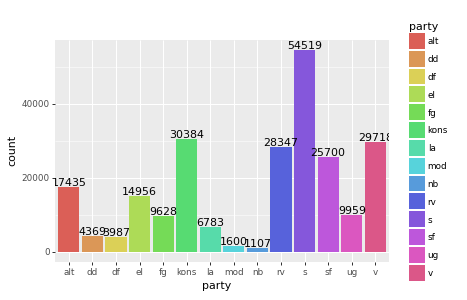

<ggplot: (8788186956785)>

In [25]:
(ggplot(tweet_merged, aes('party', fill='party'))
 + geom_bar()
 + geom_text(
     aes(label=after_stat('count')),
     stat='count',
     nudge_y=0.125,
     va='bottom'
 )
)

## Model 1: Clusteranalyse med tokens

In [26]:
nlp = spacy.load("da_core_news_sm") # Valg af NLP-model. Dansk news. 
# Der var desværre ikke udarbejdet en model til WEB på dansk

In [27]:
# Første tokenizer 
def tokenizer1(text): # defalt altid det, som skal skrives ved oprettelse af tokenizer
    
    custom_stops = [''] # Definerer kontekstspecifikke stopord
    default_stopwords = list(nlp.Defaults.stop_words) # Indlæser prædefineret stopordsliste
    stop_words = default_stopwords + custom_stops # Danner samlet stopordsliste
    
    pos_tags = ['PROPN', 'ADJ', 'NOUN'] # Definerer typer ord som skal bevares

    doc = nlp(text) # nlp 

    tokens = []

    for word in doc: # Looper igennem hvert ord i tweet
        if (len(word.lemma_) < 3): # Ord må ikke være mindre end 3 karakterer - går videre til næste ord, hvis det er
            continue
        if (word.pos_ in pos_tags) and (word.lemma_ not in stop_words): # Tjek at ordets POS-tag indgår i listen af accepterede tags og at ordet ikke er stopord
            tokens.append(word.lemma_) # Tilføj ordets lemma til tokens, hvis if-betingelse er opfyldt
                
    return(tokens)

In [ ]:
# Vi kører tokenizeren på full_text_2
tokens1 = []
for text in tweet_merged['full_text_2']:
    tokens1.append(tokenizer1(text))

In [ ]:
tokens1[0:10]

In [28]:
#vectorize
vectorizer1 = TfidfVectorizer(min_df = 300, max_df = 0.3, tokenizer = tokenizer1) # dan vectorizerfunktion - vi laver ikke om i funktionen
#Tweets skal minimum fremgå i 300 dokumenter, men ikke mere end 30% af korpus
transformed_documents1 = vectorizer1.fit_transform(tweet_merged['full_text_2']) # brug vectorizer på tekster

transformed_documents_as_array1 = transformed_documents1.toarray()# Konverter fittet vectorizer til array
# array-struktur

/opt/conda/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'


In [29]:
tokens_df1 = pd.DataFrame(transformed_documents_as_array1, columns = vectorizer1.get_feature_names_out()) # Konverter til data frame
# Før get_feature_names_out har variablene ikke nogen meningsfulde variabelnavne. 
# Variabel navne laves herved tilsvarende til det pågældende ord i et dataframe-format. 

tokens_df1

,#dkpol,;-),Danmark,Europa,København,Lars,Mette,Støjberg,Søren,aarhus,...,åbning,årsag,årti,ærlig,øje,øjeblik,økonomi,økonomisk,ønske,øvrig
0,0.0,0.0,0.550569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.407705,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238487,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
238488,0.0,0.0,0.673733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
238489,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
238490,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
tokens_df1.head()

,#dkpol,;-),Danmark,Europa,København,Lars,Mette,Støjberg,Søren,aarhus,...,åbning,årsag,årti,ærlig,øje,øjeblik,økonomi,økonomisk,ønske,øvrig
0,0.0,0.0,0.550569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.407705,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
print(tokens_df1.columns.tolist())

['#dkpol', ';-)', 'Danmark', 'Europa', 'København', 'Lars', 'Mette', 'Støjberg', 'Søren', 'aarhus', 'about', 'absurd', 'adgang', 'afghanistan', 'afgift', 'afgørende', 'afstand', 'aftale', 'aften', 'aktiv', 'almindelig', 'alternativ', 'alvor', 'alvorlig', 'ambition', 'ambitiøs', 'amerikansk', 'amp', 'analyse', 'anbefaling', 'anderledes', 'angreb', 'anledning', 'ansvar', 'ansvarlig', 'antal', 'arbejde', 'arbejdsløs', 'arbejdsmarked', 'arbejdsplads', 'argument', 'artikel', 'avis', 'baggrund', 'balance', 'bane', 'bank', 'barn', 'barsel', 'befolkning', 'behandling', 'behov', 'bekendt', 'beregning', 'berlingske', 'beskæftigelse', 'beslutning', 'besparelse', 'besøg', 'betydning', 'bidrag', 'bil', 'billede', 'billig', 'biodiversitet', 'blok', 'blå', 'bog', 'bolig', 'bord', 'borg', 'borger', 'borgerlig', 'borgmester', 'branche', 'bred', 'brug', 'bud', 'budskab', 'bund', 'bæredygtig', 'børnenes', 'can', 'central', 'chance', 'christiansborg', 'co2', 'corona', 'coronakrise', 'covid19', 'covid19dk'

In [32]:
#Cluteranalyse

In [33]:
# Vi prøver først med 20 klynger og ser 
kmeans1 = KMeans(20, random_state = 666)

In [34]:
identified_clusters1 = kmeans1.fit_predict(tokens_df1)
identified_clusters1

/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


array([13,  3,  3, ...,  3,  3,  3], dtype=int32)

In [35]:
tweet_merged['cluster_countvec1'] = identified_clusters1
tweet_merged['cluster_countvec1'] = tweet_merged['cluster_countvec1'].astype('str') # omdannes til string for at gøre den kategorisk

In [36]:
tweet_merged.groupby(['party', 'cluster_countvec1']).size() / tweet_merged.groupby(['party']).size()

party  cluster_countvec1
alt    0                    0.005506
       1                    0.009464
       10                   0.002065
       11                   0.018182
       12                   0.005105
                              ...   
v      5                    0.003197
       6                    0.011710
       7                    0.020089
       8                    0.032001
       9                    0.021166
Length: 277, dtype: float64

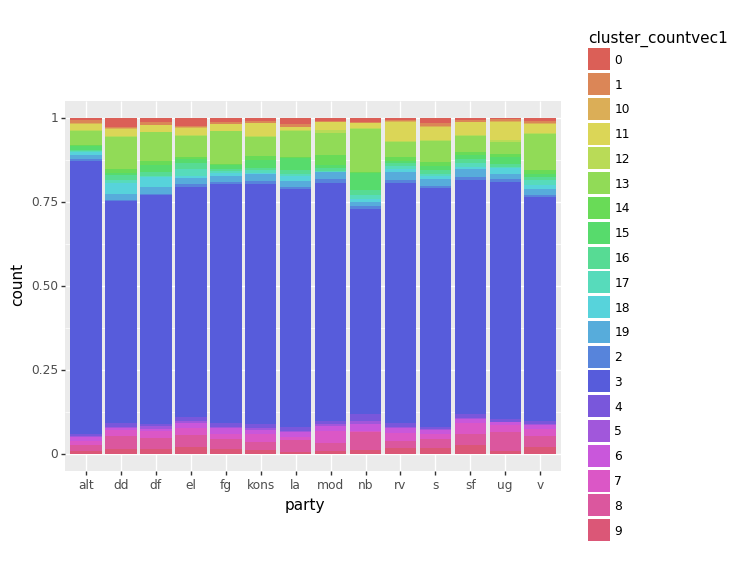

<ggplot: (8788048163079)>

In [37]:
# Visualisering
(ggplot(data = tweet_merged, mapping = aes(x = 'party', group = 'cluster_countvec1', fill = 'cluster_countvec1')) 
 + geom_bar(position = 'fill'))

In [38]:
tweet_merged.groupby(['cluster_countvec1'])['party'].count()

cluster_countvec1
0       2716
1       1360
10       651
11      8202
12       785
13     15284
14      2432
15      3169
16      2279
17      2223
18      2196
19      4654
2       1860
3     168887
4       2307
5        896
6       2896
7       4873
8       6828
9       3994
Name: party, dtype: int64

In [39]:
#Vi har vil gerne finde en mere nøjagtig mængde clusters, så vi bruger albuemetoden. Jo mere ens inden i, jo bedre

In [40]:
wcss1=[] #Tom liste, wcss står for within cluster-sum of squares
for i in range(1,14):
    kmeans1 = KMeans(i) #i er et tal mellem et og 14
    kmeans1.fit(tokens_df1)
    wcss_iter1 = kmeans1.inertia_ #in sum of squares
    wcss1.append(wcss_iter1)

/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

Text(0, 0.5, 'WCSS')

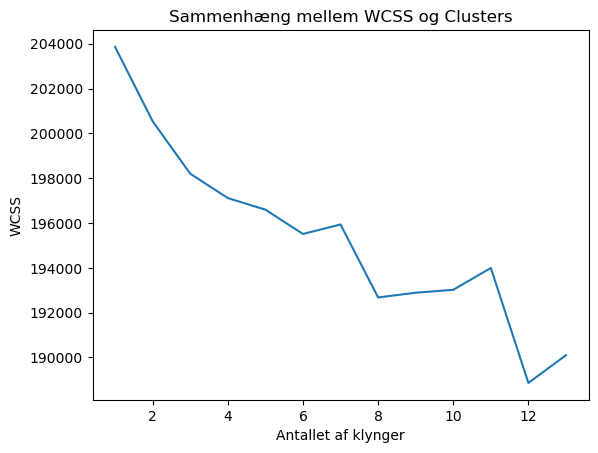

In [41]:
number_clusters1 = range(1,14)
plt.plot(number_clusters1,wcss1)
plt.title('Sammenhæng mellem WCSS og Clusters')
plt.xlabel('Antallet af klynger')
plt.ylabel('WCSS')

In [42]:
kmeans1a = KMeans(9, random_state = 666)

In [43]:
identified_clusters1a = kmeans1a.fit_predict(tokens_df1)
identified_clusters1a

/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


array([4, 0, 0, ..., 0, 0, 0], dtype=int32)

In [44]:
tweet_merged['cluster_countvec1a'] = identified_clusters1a
tweet_merged['cluster_countvec1a'] = tweet_merged['cluster_countvec1a'].astype('str') # omdannes til string for at gøre den kategorisk

In [45]:
tweet_merged.groupby(['party', 'cluster_countvec1a']).size() / tweet_merged.groupby(['party']).size()

party  cluster_countvec1a
alt    0                     0.910582
       1                     0.002065
       2                     0.015429
       3                     0.002983
       4                     0.023459
                               ...   
v      4                     0.037048
       5                     0.018642
       6                     0.029948
       7                     0.018676
       8                     0.006965
Length: 126, dtype: float64

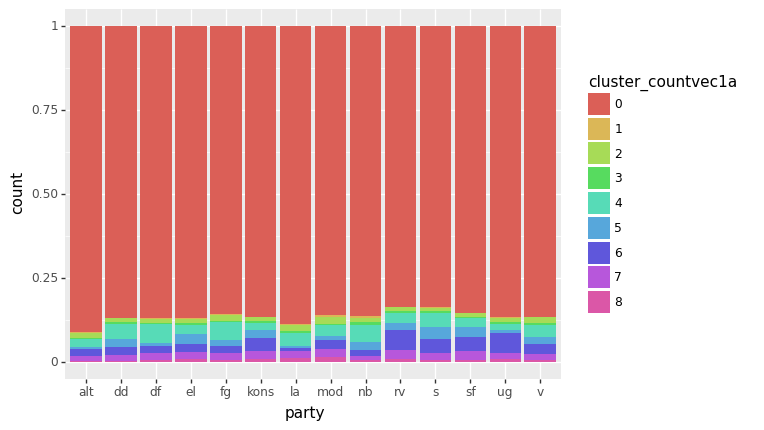

<ggplot: (8788047082343)>

In [46]:
(ggplot(data = tweet_merged, mapping = aes(x = 'party', group = 'cluster_countvec1a', fill = 'cluster_countvec1a')) 
 + geom_bar(position = 'fill'))

In [47]:
# PCA på vores model
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state= 666)

pca_vecs = pca.fit_transform(tokens_df1)

pca1 = pca_vecs[:, 0]
pca2 = pca_vecs[:, 1]

tweet_merged['pca1'] = pca1
tweet_merged['pca2'] = pca2

In [48]:
#Inspicerer indhold i clusters model 1.
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(transformed_documents1.todense()).groupby(identified_clusters1a).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer1.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)


Cluster 0
grøn,gang,barn,vigtig,dansk,enig,stor,regering,dag,dkpol

Cluster 1
parti,kær,vaccine,dansk,spørgsmål,overskrift,stor,tak,dkpol,Lars

Cluster 2
tak,samråd,kritisk,statsminister,regering,minister,dag,dkpol,svar,spørgsmål

Cluster 3
par,barn,første,sen,krone,sidste,dag,regering,dkpol,måned

Cluster 4
verden,barn,regering,grøn,dansk,stor,dag,land,dkpol,Danmark

Cluster 5
politisk,tak,vigtig,parti,dag,regering,grøn,bred,dkpol,aftale

Cluster 6
kæmpe,arbejde,dag,vigtig,stor,indsats,samarbejde,dkpol,tusind,tak

Cluster 7
vigtig,barn,tak,svær,dag,regering,stor,lang,dkpol,tid

Cluster 8
gang,tid,vigtig,stor,forskellig,dag,regering,enig,dkpol,ting


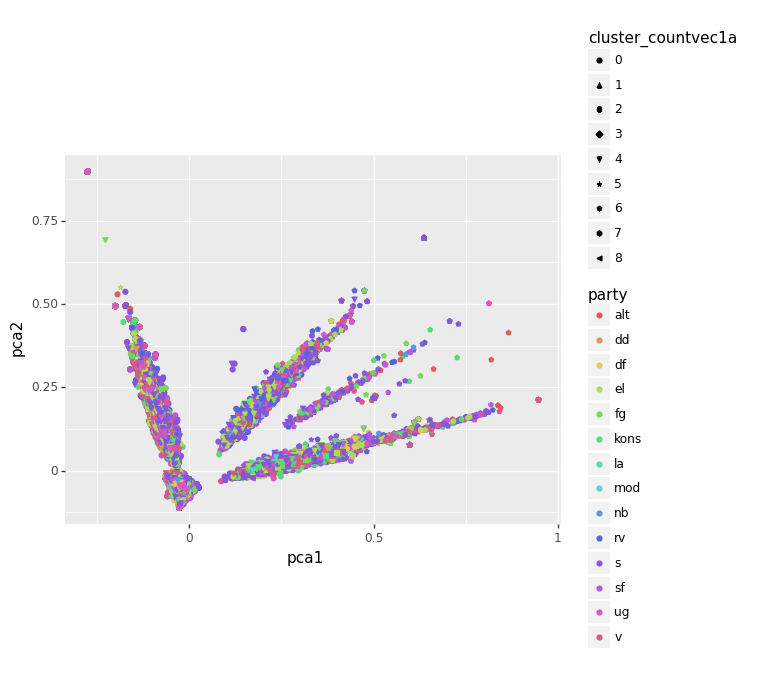

<ggplot: (8788047013367)>

In [49]:
## Så visualiserer vi.

(ggplot(data = tweet_merged, mapping = aes(x = 'pca1', y = 'pca2', shape = 'cluster_countvec1a', colour = 'party')) 
 + geom_point())

## Model 2 med nye stopord 

In [50]:
def tokenizer(text): # defalt altid det, som skal skrives ved oprettelse af tokenizer
    
    custom_stops = [';-)', 'about', 'amp', 'can', 'fast', 'fordel', 'går', 'hej', 'ift', 'ift.', 'igang', 'kær', 'let', 'masse', 'nødt', 'øvrig', 'with', 'will', 'was', 'yes', 'what'] # Definerer kontekstspecifikke stopord
    default_stopwords = list(nlp.Defaults.stop_words) # Indlæser prædefineret stopordsliste
    stop_words = default_stopwords + custom_stops # Danner samlet stopordsliste
    
    pos_tags = ['PROPN', 'ADJ', 'NOUN'] # Definerer typer ord som skal bevares

    doc = nlp(text) # nlp 

    tokens = []

    for word in doc: # Looper igennem hvert ord i tweet
        if (len(word.lemma_) < 3): # Ord må ikke være mindre end 3 karakterer - går videre til næste ord, hvis det er
            continue
        if (word.pos_ in pos_tags) and (word.lemma_ not in stop_words): # Tjek at ordets POS-tag indgår i listen af accepterede tags og at ordet ikke er stopord
            tokens.append(word.lemma_) # Tilføj ordets lemma til tokens, hvis if-betingelse er opfyldt
                
    return(tokens)

In [51]:
# Vi kører tokenizeren på full_text_2
tokens2 = []
for text in tweet_merged['full_text_2']:
    tokens2.append(tokenizer(text))

NameError: name 'tokens' is not defined

In [ ]:
tokens2[0:10]

## Vectorizer med vores nye tokenizer.

In [52]:
#vectorize
vectorizer2 = TfidfVectorizer(min_df = 400, max_df = 0.25, tokenizer = tokenizer) # dan vectorizerfunktion - vi laver ikke om i funktionen
#Tweets skal minimum fremgå i 300 dokumenter, men ikke mere end 30% af korpus
transformed_documents2 = vectorizer2.fit_transform(tweet_merged['full_text_2']) # brug vectorizer på tekster

transformed_documents_as_array2 = transformed_documents2.toarray()# Konverter fittet vectorizer til array
# array-struktur

/opt/conda/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'


In [53]:
tokens_df2 = pd.DataFrame(transformed_documents_as_array2, columns = vectorizer2.get_feature_names_out()) # Konverter til data frame
# Før get_feature_names_out har variablene ikke nogen meningsfulde variabelnavne. 
# Variabel navne laves herved tilsvarende til det pågældende ord i et dataframe-format. 

tokens_df2

,Danmark,Europa,København,Lars,Mette,Søren,aarhus,adgang,afgift,afgørende,...,værdi,weekend,world,åben,åbning,årsag,øje,økonomi,økonomisk,ønske
0,0.550569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238487,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
238488,0.673733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
238489,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
238490,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
print(tokens_df2.columns.tolist())

['Danmark', 'Europa', 'København', 'Lars', 'Mette', 'Søren', 'aarhus', 'adgang', 'afgift', 'afgørende', 'afstand', 'aftale', 'aften', 'almindelig', 'alvor', 'alvorlig', 'ambition', 'ambitiøs', 'analyse', 'anbefaling', 'anderledes', 'angreb', 'ansvar', 'ansvarlig', 'antal', 'arbejde', 'arbejdsmarked', 'arbejdsplads', 'argument', 'artikel', 'avis', 'baggrund', 'bane', 'bank', 'barn', 'barsel', 'befolkning', 'behandling', 'behov', 'bekendt', 'beslutning', 'besparelse', 'besøg', 'betydning', 'bil', 'billede', 'billig', 'biodiversitet', 'blok', 'blå', 'bog', 'bolig', 'bord', 'borg', 'borger', 'borgerlig', 'borgmester', 'bred', 'brug', 'bud', 'budskab', 'bæredygtig', 'chance', 'christiansborg', 'co2', 'corona', 'coronakrise', 'covid19', 'covid19dk', 'dag', 'danmark', 'dansk', 'dansker', 'debat', 'debatt', 'dejlig', 'del', 'demokrati', 'demokratisk', 'denmark', 'dialog', 'diskussion', 'dkaid', 'dkbiz', 'dkgre', 'dkmedi', 'dkmedie', 'dkpol', 'dktrp', 'dygtig', 'dyr', 'dårlig', 'død', 'effekt',

In [55]:
#Cluteranalyse

In [56]:
# Justeret til 7 clusters, baseret på den forige albuetest.
kmeans2 = KMeans(7, random_state = 666)

In [57]:
identified_clusters2 = kmeans2.fit_predict(tokens_df2)
identified_clusters2

/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


array([3, 3, 3, ..., 3, 3, 3], dtype=int32)

In [58]:
tweet_merged['cluster_countvec2'] = identified_clusters2
tweet_merged['cluster_countvec2'] = tweet_merged['cluster_countvec2'].astype('str') # omdannes til string for at gøre den kategorisk

In [59]:
tweet_merged.groupby(['party', 'cluster_countvec2']).size() / tweet_merged.groupby(['party']).size()

party  cluster_countvec2
alt    0                    0.011701
       1                    0.015945
       2                    0.021967
       3                    0.798107
       4                    0.010783
                              ...   
v      2                    0.030857
       3                    0.693687
       4                    0.010835
       5                    0.000909
       6                    0.222727
Length: 97, dtype: float64

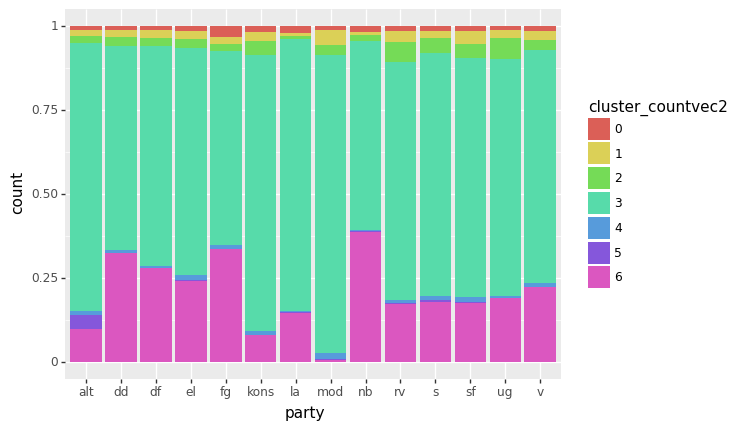

<ggplot: (8788047085258)>

In [60]:

(ggplot(data = tweet_merged, mapping = aes(x = 'party', group = 'cluster_countvec2', fill = 'cluster_countvec2')) 
 + geom_bar(position = 'fill'))

In [61]:
tweet_merged.groupby(['cluster_countvec2'])['party'].count()

cluster_countvec2
0      3615
1      5953
2      9412
3    172800
4      2678
5      1333
6     42701
Name: party, dtype: int64

In [62]:
## PCA på vores model
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state= 666)

pca_vecs = pca.fit_transform(tokens_df2)

pca1 = pca_vecs[:, 0]
pca2 = pca_vecs[:, 1]

tweet_merged['pca1'] = pca1
tweet_merged['pca2'] = pca2

In [63]:
# Oversigt over indhold i hver cluster og dens tokens
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(transformed_documents2.todense()).groupby(identified_clusters2).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer2.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10) #Vi vælger selv, hvor mange ord fra clusteren vi gerne vil se


Cluster 0
tid,stor,verden,land,penge,Danmark,dag,regering,dkpol,sted

Cluster 1
parti,gang,brug,stor,dag,vigtig,tak,regering,dkpol,enig

Cluster 2
ord,arbejde,dag,vigtig,indsats,stor,samarbejde,dkpol,tusind,tak

Cluster 3
grøn,aftale,gang,barn,vigtig,dansk,Danmark,stor,regering,dag

Cluster 4
respekt,problem,sejr,dag,indsats,stor,dkpol,tak,tillykke,kæmpe

Cluster 5
hong,the,dkpol,mor,world,time,denmark,that,from,this

Cluster 6
vigtig,grøn,dkmedi,dansk,stor,Danmark,dag,dkgre,regering,dkpol


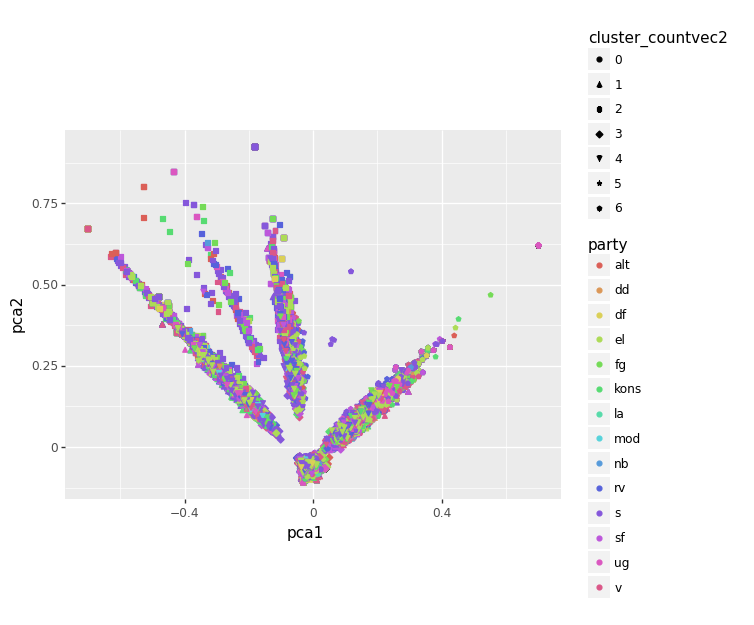

<ggplot: (8788048151047)>

In [64]:
# Plot over PCA modellen
(ggplot(data = tweet_merged, mapping = aes(x = 'pca1', y = 'pca2', shape = 'cluster_countvec2', colour = 'party')) 
 + geom_point())

### Model 3: Uni- og bigramsmodel

In [59]:
#vectorize
vectorizer3 = TfidfVectorizer(min_df = 300, max_df = 0.3, tokenizer = tokenizer1, ngram_range =(1,2)) # dan vectorizerfunktion - vi laver ikke om i funktionen
transformed_documents3 = vectorizer3.fit_transform(tweet_merged['full_text_2']) # brug vectorizer på tekster

transformed_documents_as_array3 = transformed_documents3.toarray()# Konverter fittet vectorizer til array
# array-struktur

/opt/conda/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'


In [60]:
tokens_df3 = pd.DataFrame(transformed_documents_as_array3, columns = vectorizer3.get_feature_names_out()) # Konverter til data frame
# Før get_feature_names_out har variablene ikke nogen meningsfulde variabelnavne. 
# Variabel navne laves herved tilsvarende til det pågældende ord i et dataframe-format. 

tokens_df3

,#dkpol,;-),Danmark,Danmark dkpol,Europa,København,Lars,Mette,Mette frederikse,Støjberg,...,åbning,årsag,årti,ærlig,øje,øjeblik,økonomi,økonomisk,ønske,øvrig
0,0.0,0.0,0.550569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.407705,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238487,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
238488,0.0,0.0,0.673733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
238489,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
238490,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
print(tokens_df3.columns.tolist())

['#dkpol', ';-)', 'Danmark', 'Danmark dkpol', 'Europa', 'København', 'Lars', 'Mette', 'Mette frederikse', 'Støjberg', 'Søren', 'aarhus', 'about', 'absurd', 'adgang', 'afghanistan', 'afgift', 'afgørende', 'afstand', 'aftale', 'aften', 'aktiv', 'almindelig', 'alternativ', 'alvor', 'alvorlig', 'ambition', 'ambitiøs', 'amerikansk', 'amp', 'analyse', 'anbefaling', 'anderledes', 'angreb', 'anledning', 'ansvar', 'ansvarlig', 'antal', 'arbejde', 'arbejdsløs', 'arbejdsmarked', 'arbejdsplads', 'argument', 'artikel', 'avis', 'baggrund', 'balance', 'bane', 'bank', 'barn', 'barn ung', 'barsel', 'befolkning', 'behandling', 'behov', 'bekendt', 'beregning', 'berlingske', 'beskæftigelse', 'beslutning', 'besparelse', 'besøg', 'betydning', 'bidrag', 'bil', 'billede', 'billig', 'biodiversitet', 'blok', 'blå', 'blå blok', 'blå parti', 'bog', 'bolig', 'bord', 'borg', 'borger', 'borgerlig', 'borgmester', 'branche', 'bred', 'bred aftale', 'bred flertal', 'brug', 'bud', 'budskab', 'bund', 'bæredygtig', 'børnen

In [109]:
#clusteranalyse - K-means
kmeans3 = KMeans(7, random_state = 666)

In [110]:
identified_clusters3 = kmeans3.fit_predict(tokens_df3)
identified_clusters3

/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


array([2, 2, 2, ..., 2, 3, 3], dtype=int32)

In [111]:
tweet_merged['cluster_countvec3'] = identified_clusters3
tweet_merged['cluster_countvec3'] = tweet_merged['cluster_countvec3'].astype('str') # omdannes til string for at gøre den kategorisk

In [112]:
tweet_merged.groupby(['party', 'cluster_countvec3']).size() / tweet_merged.groupby(['party']).size()

party  cluster_countvec3
alt    0                    0.091597
       1                    0.018583
       2                    0.796903
       3                    0.053456
       4                    0.013421
                              ...   
v      2                    0.659970
       3                    0.049970
       4                    0.020829
       5                    0.022512
       6                    0.013325
Length: 98, dtype: float64

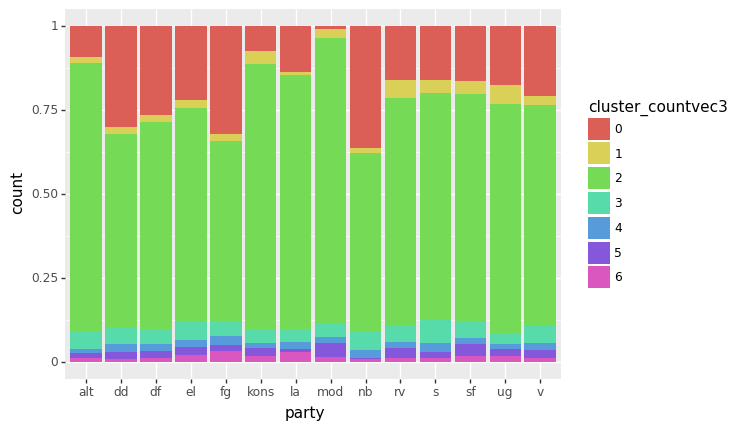

<ggplot: (8787656931166)>

In [113]:
(ggplot(data = tweet_merged, mapping = aes(x = 'party', group = 'cluster_countvec3', fill = 'cluster_countvec3')) 
 + geom_bar(position = 'fill'))

In [164]:
tweet_merged.groupby(['cluster_countvec3'])['party'].count()

cluster_countvec3
0      4719
1    192549
2     11558
3     10498
4      5562
5      5344
6      8262
Name: party, dtype: int64

In [165]:
cluster_ngram = tweet_merged['cluster_countvec3']

In [166]:
cluster_ngram.head()

0    1
1    1
2    1
3    1
4    1
Name: cluster_countvec3, dtype: object

In [167]:
partier = tweet_merged['party']

In [119]:
pd.crosstab(tweet_merged['party'],tweet_merged['cluster_countvec3'], normalize = 'index') #krydstabel over fordeling af kluster på partier

cluster_countvec3,0,1,2,3,4,5,6
party,,,,,,,
alt,0.091597,0.018583,0.796903,0.053456,0.013421,0.014167,0.011873
dd,0.301442,0.020600,0.573587,0.049897,0.023575,0.020371,0.010529
df,0.265112,0.018560,0.620767,0.042388,0.019814,0.020818,0.012541
el,0.220781,0.021998,0.636534,0.055697,0.019725,0.022600,0.022666
fg,0.321874,0.018592,0.536975,0.043311,0.027628,0.017449,0.034171
kons,0.074381,0.037915,0.791140,0.040449,0.013033,0.026001,0.017081
la,0.135486,0.008551,0.756450,0.040543,0.019903,0.008403,0.030665
mod,0.006875,0.026875,0.848125,0.043750,0.016875,0.041875,0.015625
nb,0.362240,0.015357,0.528455,0.057814,0.023487,0.004517,0.008130


In [169]:
#Laver PCA model for at inspicere clusters
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state= 666)

pca_vecs = pca.fit_transform(tokens_df3)

pca1 = pca_vecs[:, 0]
pca2 = pca_vecs[:, 1]

tweet_merged['pca1'] = pca1
tweet_merged['pca2'] = pca2

In [120]:
## Så visualiserer vi.
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(transformed_documents3.todense()).groupby(identified_clusters3).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer3.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10) #Vi vælger selv, hvor mange ord fra clusteren vi gerne vil se


Cluster 0
vigtig,dkmedi,grøn,stor,dansk,Danmark,dkpol dkgre,dkgre,regering,dkpol

Cluster 1
arbejde,stor,tak samarbejde,vigtig,samarbejde,dkpol,indsats,tusind,tusind tak,tak

Cluster 2
grøn,tid,aftale,dansk,barn,gang,vigtig,Danmark,stor,regering

Cluster 3
dansk,folketing,vigtig,Danmark,tak,dag dkpol,regering,stor,dkpol,dag

Cluster 4
aftale,dansk,vigtig,regering,dag,verden,stor,Danmark,dkpol,land

Cluster 5
parti,gang,forslag,stor,brug,vigtig,regering,tak,dkpol,enig

Cluster 6
tak,folk,Danmark,stor,dag,liv,ung,handicap,dkpol,menneske


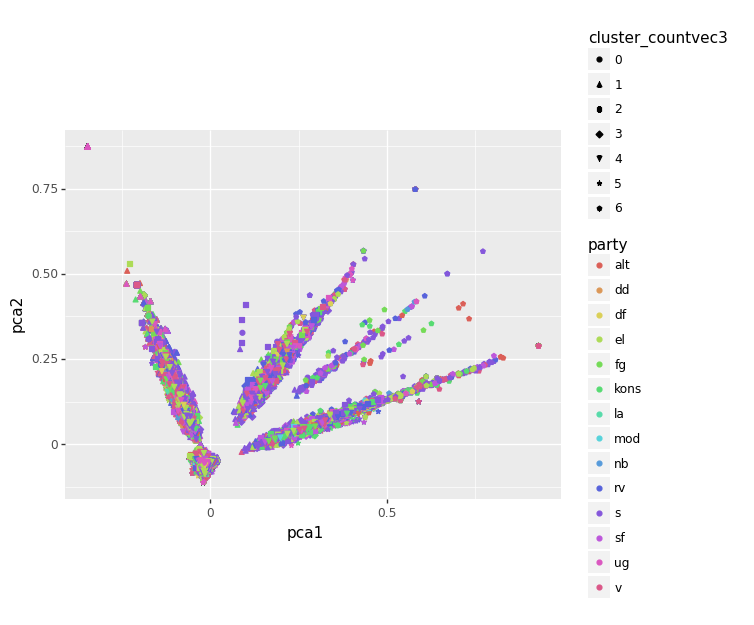

<ggplot: (8763582047106)>

In [171]:
(ggplot(data = tweet_merged, mapping = aes(x = 'pca1', y = 'pca2', shape = 'cluster_countvec3', colour = 'party')) 
 + geom_point())

### Model 4: Clusteranalyse på bigrams

In [121]:
#vectorize
#Ændrer min_df til 200 i et forsøg på flere bigrams
vectorizer4 = TfidfVectorizer(min_df = 280, max_df = 0.25, tokenizer = tokenizer, ngram_range =(2,2)) # dan vectorizerfunktion - vi laver ikke om i funktionen
transformed_documents4 = vectorizer4.fit_transform(tweet_merged['full_text_2']) # brug vectorizer på tekster

transformed_documents_as_array4 = transformed_documents4.toarray()# Konverter fittet vectorizer til array
# array-struktur

/opt/conda/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'


In [122]:
tokens_df4 = pd.DataFrame(transformed_documents_as_array4, columns = vectorizer4.get_feature_names_out()) # Konverter til data frame
# Før get_feature_names_out har variablene ikke nogen meningsfulde variabelnavne. 
# Variabel navne laves herved tilsvarende til det pågældende ord i et dataframe-format. 

tokens_df4

,Danmark dkpol,Mette frederikse,arbejde dkpol,barn ung,blå blok,blå parti,bred aftale,bred flertal,dag dkpol,dansk politik,...,politisk aftale,regering dkpol,stor tak,stor tillykke,tak dkpol,tak indsats,tak samarbejde,tidlig pension,tusind tak,udsat barn
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
238488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
238489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
238490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
bigram_listen =  print(tokens_df4.columns.tolist())

['Danmark dkpol', 'Mette frederikse', 'arbejde dkpol', 'barn ung', 'blå blok', 'blå parti', 'bred aftale', 'bred flertal', 'dag dkpol', 'dansk politik', 'dansk økonomi', 'dkgre dkpol', 'dkpol dkgre', 'dkpol dkmedi', 'dkpol dkmedie', 'dkpol dktrp', 'dkpol ftliv', 'dkpol uddpol', 'flertal folketing', 'folketing parti', 'fri grøn', 'første gang', 'grøn omstilling', 'grøn skattereform', 'hong kong', 'høj grad', 'lang tid', 'mette frederikse', 'milliard krone', 'million krone', 'politisk aftale', 'regering dkpol', 'stor tak', 'stor tillykke', 'tak dkpol', 'tak indsats', 'tak samarbejde', 'tidlig pension', 'tusind tak', 'udsat barn']


In [124]:
#clusteranalyse - K-means
kmeans4 = KMeans(7, random_state = 666)

In [125]:
identified_clusters4 = kmeans4.fit_predict(tokens_df4)
identified_clusters4

/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [126]:
tweet_merged['cluster_countvec4'] = identified_clusters4
tweet_merged['cluster_countvec4'] = tweet_merged['cluster_countvec4'].astype('str') # omdannes til string for at gøre den kategorisk

In [127]:
tweet_merged.groupby(['party', 'cluster_countvec4']).size() / tweet_merged.groupby(['party']).size()

party  cluster_countvec4
alt    0                    0.987955
       1                    0.003785
       2                    0.001147
       3                    0.002925
       4                    0.003613
                              ...   
v      2                    0.020728
       3                    0.013729
       4                    0.007235
       5                    0.008042
       6                    0.000538
Length: 84, dtype: float64

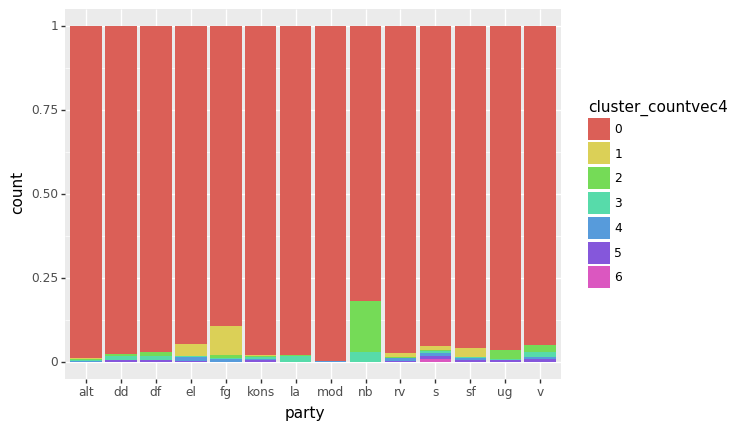

<ggplot: (8787838672517)>

In [128]:
(ggplot(data = tweet_merged, mapping = aes(x = 'party', group = 'cluster_countvec4', fill = 'cluster_countvec4')) 
 + geom_bar(position = 'fill'))

In [129]:
tweet_merged.groupby(['cluster_countvec4'])['party'].count()

cluster_countvec4
0    228984
1      2981
2      1656
3      1412
4      1586
5      1253
6       620
Name: party, dtype: int64

In [130]:
cluster_ngram = tweet_merged['cluster_countvec4']

In [131]:
cluster_ngram.head()

0    0
1    0
2    0
3    0
4    0
Name: cluster_countvec4, dtype: object

In [132]:
partier = tweet_merged['party']

In [133]:
pd.crosstab(tweet_merged['party'],tweet_merged['cluster_countvec4'], normalize = 'index') #krydstabel over fordeling af kluster på partier

cluster_countvec4,0,1,2,3,4,5,6
party,,,,,,,
alt,0.987955,0.003785,0.001147,0.002925,0.003613,0.000574,0.000000
dd,0.975967,0.000229,0.005493,0.010758,0.000687,0.006867,0.000000
df,0.969150,0.000251,0.012792,0.011287,0.000752,0.005769,0.000000
el,0.946643,0.033565,0.001872,0.003276,0.012436,0.002206,0.000000
fg,0.893020,0.085272,0.008413,0.005089,0.006959,0.001246,0.000000
kons,0.979496,0.001909,0.001810,0.006813,0.003160,0.006813,0.000000
la,0.979360,0.000000,0.000737,0.017839,0.001622,0.000442,0.000000
mod,0.996250,0.000000,0.000000,0.000625,0.001875,0.001250,0.000000
nb,0.817525,0.000000,0.150858,0.029810,0.000903,0.000903,0.000000


In [134]:
wcss4 = []
for i in range(1, 16):
    kmeans4 = KMeans(i)
    kmeans4.fit(tokens_df4)
    wcss_iter4 = kmeans4.inertia_
    wcss4.append(wcss_iter4)

/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

Text(0, 0.5, 'WCSS')

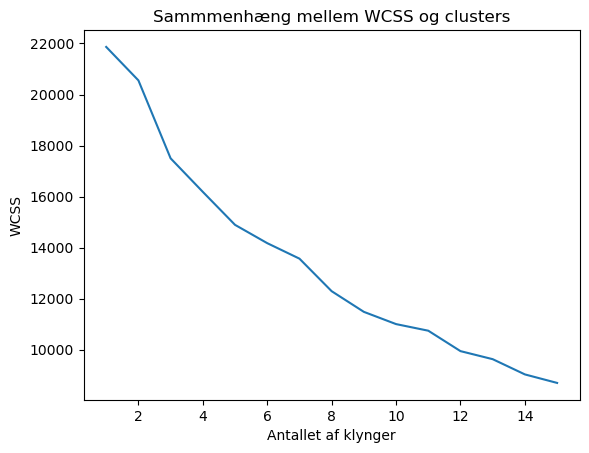

In [135]:
number_clusters4 = range(1, 16)
plt.plot(number_clusters4, wcss4)
plt.title('Sammmenhæng mellem WCSS og clusters')
plt.xlabel('Antallet af klynger')
plt.ylabel('WCSS')

### Inspicer bigram fordeling på cluster model 4: Bigrams

In [53]:
# foretager PCA-model

pca = PCA(n_components=2, random_state= 666)

pca_vecs = pca.fit_transform(tokens_df4)

pca1 = pca_vecs[:, 0]
pca2 = pca_vecs[:, 1]

tweet_merged['pca1'] = pca1
tweet_merged['pca2'] = pca2

In [138]:
#udtrækker top tokens i clusters
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(transformed_documents4.todense()).groupby(identified_clusters4).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer4.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)


Cluster 0
hong kong,første gang,tak dkpol,dag dkpol,dkgre dkpol,Danmark dkpol,million krone,tusind tak,milliard krone,barn ung

Cluster 1
bred aftale,arbejde dkpol,regering dkpol,million krone,milliard krone,dag dkpol,tak dkpol,Danmark dkpol,grøn skattereform,dkpol dkgre

Cluster 2
blå parti,fri grøn,mette frederikse,milliard krone,lang tid,tak dkpol,Danmark dkpol,dag dkpol,regering dkpol,dkpol dkmedi

Cluster 3
første gang,blå blok,dansk økonomi,grøn omstilling,mette frederikse,dansk politik,dkpol ftliv,dkpol dkmedi,dkpol dkgre,Mette frederikse

Cluster 4
regering dkpol,Danmark dkpol,dkpol dkmedi,dkpol ftliv,bred aftale,dkgre dkpol,milliard krone,grøn skattereform,dkpol dkgre,grøn omstilling

Cluster 5
første gang,udsat barn,grøn omstilling,dkpol dkmedi,Danmark dkpol,dkpol dkgre,tak indsats,tak samarbejde,stor tak,stor tillykke

Cluster 6
stor tak,tak samarbejde,tak dkpol,bred flertal,Danmark dkpol,dag dkpol,arbejde dkpol,million krone,grøn omstilling,dkpol dktrp


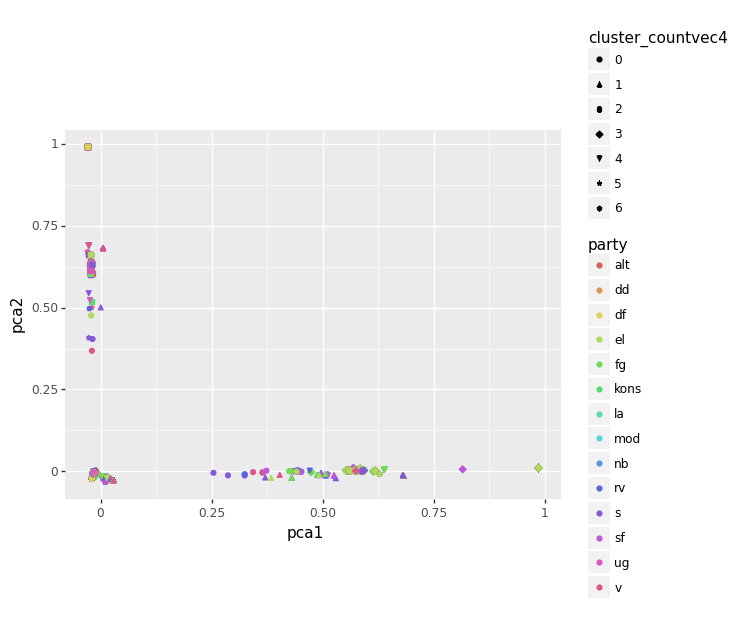

<ggplot: (8766105350376)>

In [59]:
#visualisering
(ggplot(data = tweet_merged, mapping = aes(x = 'pca1', y = 'pca2', shape = 'cluster_countvec4', colour = 'party')) 
 + geom_point())